In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  import tensorflow.compat.v2 as tf
except Exception:
  import tensorflow as tf

tf.enable_v2_behavior()

print(tf.__version__)

2.2.0


In [ ]:
!jupyter nbconvert --to html rock_identifier.ipynb

[NbConvertApp] Converting notebook rock_identifier.ipynb to html
[NbConvertApp] Writing 1574205 bytes to rock_identifier.html


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
path= '/content/drive/My Drive/Garbage data'  #change dir to your project folder

In [6]:
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

2527

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['glass', 'metal', 'paper', 'plastic', 'cardboard', 'trash'],
      dtype='<U9')

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCS = 20

In [9]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [10]:
def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

In [11]:
def color(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [12]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [13]:
def zoom(x: tf.Tensor) -> tf.Tensor:

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMG_SIZE, IMG_SIZE))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

In [14]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))

In [15]:
train_size = int(0.7 * image_count)
val_size = int(0.2 * image_count)
test_size = image_count - train_size - val_size

print("Total Images     : ", image_count)
print("train Images     : ", train_size)
print("validation Images: ", val_size)
print("test Images      : ", test_size)

SUFFLE_BUFFER_SIZE = int(test_size/2)
STEPS_PER_EPOCH = np.ceil(train_size/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(val_size/BATCH_SIZE)

full_list_dataset = list_ds.shuffle(buffer_size=SUFFLE_BUFFER_SIZE)
train_list_dataset = full_list_dataset.take(train_size)
test_list_dataset = full_list_dataset.skip(train_size)
val_list_dataset = test_list_dataset.take(val_size)
test_list_dataset = test_list_dataset.skip(val_size)

Total Images     :  2527
train Images     :  1768
validation Images:  505
test Images      :  254


In [16]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES 

In [17]:
image_path = next(iter(test_list_dataset))
print(image_path)

tf.Tensor(b'/content/drive/My Drive/Garbage data/cardboard/cardboard95.jpg', shape=(), dtype=string)


In [18]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [19]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [20]:
def process_path_flip(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = flip(img)
  return img, label

In [21]:
def process_path_color(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = color(img)
  return img, label

In [22]:
def process_path_rotate(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = rotate(img)
  return img, label

In [23]:
def process_path_zoom(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = zoom(img)
  return img, label

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_normal_ds = train_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_flipped_ds = train_list_dataset.map(process_path_flip, num_parallel_calls=AUTOTUNE)
labeled_color_ds = train_list_dataset.map(process_path_color, num_parallel_calls=AUTOTUNE)
labeled_rotate_ds = train_list_dataset.map(process_path_rotate, num_parallel_calls=AUTOTUNE)
labeled_zoomed_ds = train_list_dataset.map(process_path_zoom, num_parallel_calls=AUTOTUNE)

train_dataset = labeled_normal_ds
train_dataset = train_dataset.concatenate(labeled_flipped_ds)
train_dataset = train_dataset.concatenate(labeled_flipped_ds)
train_dataset = train_dataset.concatenate(labeled_rotate_ds)
train_dataset = train_dataset.concatenate(labeled_zoomed_ds)


labeled_normal_ds = val_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_flipped_ds = val_list_dataset.map(process_path_flip, num_parallel_calls=AUTOTUNE)
labeled_color_ds = val_list_dataset.map(process_path_color, num_parallel_calls=AUTOTUNE)
labeled_rotate_ds = val_list_dataset.map(process_path_rotate, num_parallel_calls=AUTOTUNE)
labeled_zoomed_ds = val_list_dataset.map(process_path_zoom, num_parallel_calls=AUTOTUNE)

val_dataset = labeled_normal_ds
val_dataset = val_dataset.concatenate(labeled_flipped_ds)
val_dataset = val_dataset.concatenate(labeled_flipped_ds)
val_dataset = val_dataset.concatenate(labeled_rotate_ds)
val_dataset = val_dataset.concatenate(labeled_zoomed_ds)

In [25]:
def prepare_for_training(ds, cache=False, shuffle_buffer_size=SUFFLE_BUFFER_SIZE):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

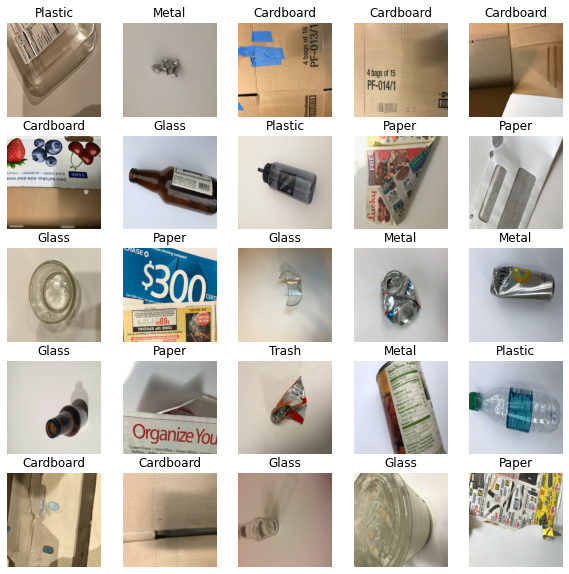

In [26]:
train_ds = prepare_for_training(train_dataset)

train_image_batch, train_label_batch = next(iter(train_ds))

show_batch(train_image_batch.numpy(), train_label_batch.numpy())

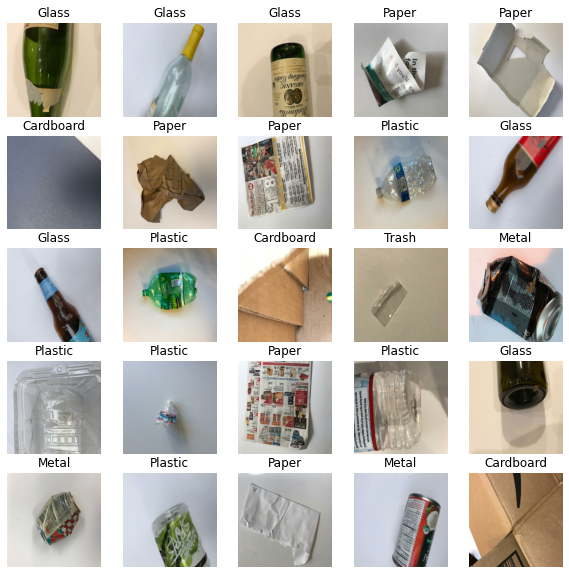

In [27]:
val_ds = prepare_for_training(val_dataset)

val_image_batch, val_label_batch = next(iter(val_ds))

show_batch(val_image_batch.numpy(), val_label_batch.numpy())

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, Activation, MaxPooling2D

In [29]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), data_format='channels_last'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(84))
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(len(CLASS_NAMES), activation='softmax'))


In [30]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
if not os.path.exists('models'):
  os.mkdir('models')

if not os.path.exists('models/checkpoints'):
  os.mkdir('models/checkpoints/')

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import  ModelCheckpoint

# checkpoint
filepath="models/checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Using TensorFlow backend.


In [32]:
history = model.fit_generator(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCS,
    validation_data=val_ds,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.7334 - accuracy: 0.2807
Epoch 00001: val_accuracy improved from -inf to 0.42188, saving model to models/checkpoints/weights-improvement-01-0.42.hdf5
56/56 [==============================] - 173s 3s/step - loss: 2.7334 - accuracy: 0.2807 - val_loss: 1.4420 - val_accuracy: 0.4219
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.4733 - accuracy: 0.3956
Epoch 00002: val_accuracy improved from 0.42188 to 0.51953, saving model to models/checkpoints/weights-improvement-02-0.52.hdf5
56/56 [==============================] - 83s 1s/step - loss: 1.4733 - accuracy: 0.3956 - val_loss: 1.3283 - val_accuracy: 0.5195
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.4280
Epoch 00003: val_accuracy did not improve from 0.51953
56/56 [==============================] - 19s 343ms/step - loss: 1.4013 - ac

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0

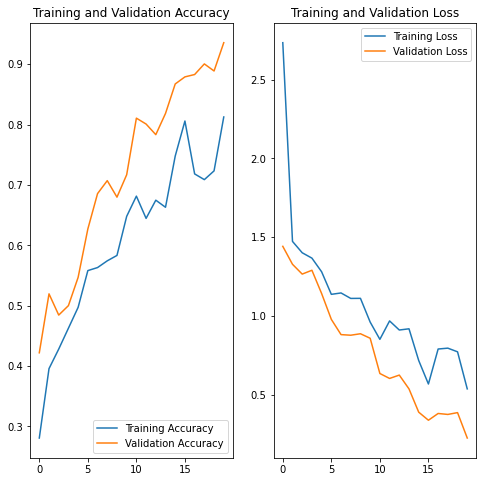

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
def load_image(img_path, show = False):
    img_tensor, label = process_path(img_path) # Image With(height, width, channels)

    if show:
        plt.imshow(img_tensor.numpy())
        plt.title(CLASS_NAMES[label.numpy()==1][0].title())
        plt.axis('off')
        plt.show()

    img_tensor = np.expand_dims(img_tensor, axis=0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    
    return img_tensor, label

In [36]:
test_images = []
true_labels = []
for p in test_list_dataset.take(test_size):
  i, l = load_image(p, False)
  test_images.append(i)
  true_labels.append(l)

In [37]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [38]:
predictions = model.predict_generator(test_dataset)

Instructions for updating:
Please use Model.predict, which supports generators.


In [39]:
predict_labels = []
for pred in predictions:
  max_value = max(pred)
  boolArr = (pred == max_value)
  predict_labels.append(boolArr)

In [40]:
true_labels = np.argmax(true_labels, axis=1)
predict_labels = np.argmax(predict_labels, axis=1)

In [41]:
from sklearn.metrics import classification_report
confusion = tf.math.confusion_matrix(labels=true_labels, predictions=predict_labels, num_classes=len(CLASS_NAMES))
print(classification_report(true_labels, predict_labels, target_names=CLASS_NAMES))
print(confusion)

              precision    recall  f1-score   support

       glass       0.96      0.86      0.91        58
       metal       0.90      0.98      0.94        46
       paper       0.91      0.98      0.94        61
     plastic       0.92      0.90      0.91        50
   cardboard       1.00      0.96      0.98        25
       trash       1.00      0.93      0.96        14

    accuracy                           0.93       254
   macro avg       0.95      0.94      0.94       254
weighted avg       0.94      0.93      0.93       254

tf.Tensor(
[[50  2  2  4  0  0]
 [ 1 45  0  0  0  0]
 [ 0  1 60  0  0  0]
 [ 0  1  4 45  0  0]
 [ 1  0  0  0 24  0]
 [ 0  1  0  0  0 13]], shape=(6, 6), dtype=int32)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


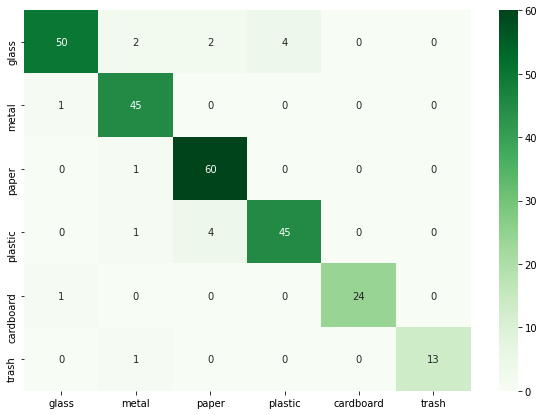

In [42]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(confusion, index = [i for i in CLASS_NAMES],
                    columns = [i for i in CLASS_NAMES], dtype=float)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Greens")
plt.show()

Image path:  b'/content/drive/My Drive/Garbage data/glass/glass44.jpg'


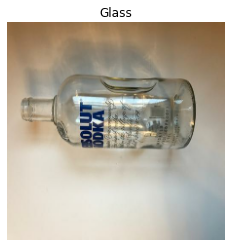

In [43]:
#single image prediction
image_path = next(iter(test_list_dataset))
print('Image path: ', image_path.numpy())
img, lbl = load_image(image_path, True)
pred = model.predict(img)
pred = pred[0]

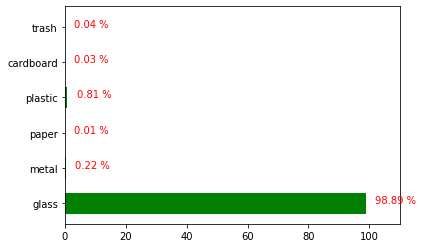

In [44]:
x = CLASS_NAMES
x_pos = [i for i, _ in enumerate(x)]
y_pos = [(per * 100) for per in pred]
plt.barh(x_pos, y_pos, height=0.6, color='green')


for i, v in enumerate(y_pos):
  val = str("{0:.2f}".format(v)) + ' %'
  plt.text(v + 3, i , val, color='red')

plt.yticks(x_pos, x)
plt.xlim([0,110])
plt.show()

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

if not os.path.exists('models/trained'):
  os.mkdir('models/trained')

In [ ]:
# Saving as .h5 model

model.save('models/trained/model.h5')

In [ ]:
# Saving as .tflite model

''' Covnvert from saved model
converter = tf.lite.TFLiteConverter.from_saved_model('models/trained/model.h5')
'''

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("models/trained/model_lite.tflite", "wb").write(tflite_quantized_model)

2331160